In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.models import Model
import pickle

In [3]:
#Load the processed dataset
data=pd.read_csv("Final.csv")

In [4]:
#Separates the independent variables and dependent variable into x and y
columns = [x for x in data.columns if x not in ['Facebook_scaled','LinkedIn_scaled','GooglePlus_scaled']]
x = data[columns]
y = data[['Facebook_scaled']]

#Splits the dataset into 70 percent training set and 30 percent testing set
# keeping the random_state value same makes the function to split same rows into training and testing every time
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=30)

In [9]:
#creates 10layer Artificial neural network model
inp= Input(shape=(1018, ))
x = Dense(2048,activation='relu')(inp)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(8,activation='relu')(x)
out = Dense(1,activation='linear')(x)
normal_model=Model(inputs=inp,outputs=out)
normal_model.compile('adam','mean_squared_error')

In [10]:
from datetime import timedelta
import time

#Time returns the elapsed time in seconds. This function converts that into hours, minutes and seconds
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec) 
start = time.time()
normal_model.fit(x_train, y_train.values.ravel(),epochs=20,batch_size=128)

normal_predictions = normal_model.predict(x_test)
k=len(list(x_train.columns))
n = len(normal_predictions)
stop = (time.time() - start)

#Calculates and prints the time taken for training the Artificial neural network
print('Elapsed Time:', convert_to_preferred_format(stop))
print('======'*5)
print("Before GridSearchCV")
print('======'*5)

#Evaluation metrics for the unoptimized Artificial neural network on test set
Metrics={}
Metrics['MSE']=[mean_squared_error(y_test,normal_predictions)]
Metrics['RMSE']=[np.sqrt(mean_squared_error(y_test,normal_predictions))]
Metrics['R2_Score']=[r2_score(y_test,normal_predictions)]
Metrics['Adjusted_R2_score']=[1 - ((1-r2_score(y_test,normal_predictions))*(n-1)/(n-k-1))]
metrics_df = pd.DataFrame(Metrics)
print(metrics_df)
normal_model.save('DL_model')

Epoch 1/50
479/479 [==============================] - 3s 5ms/step - loss: 1.2361
Epoch 2/50
479/479 [==============================] - 2s 4ms/step - loss: 0.4826
Epoch 3/50
479/479 [==============================] - 2s 4ms/step - loss: 0.3476
Epoch 4/50
479/479 [==============================] - 2s 4ms/step - loss: 0.2609
Epoch 5/50
479/479 [==============================] - 2s 4ms/step - loss: 0.4985
Epoch 6/50
479/479 [==============================] - 2s 4ms/step - loss: 0.1817
Epoch 7/50
479/479 [==============================] - 2s 4ms/step - loss: 0.1404
Epoch 8/50
479/479 [==============================] - 2s 4ms/step - loss: 0.1253
Epoch 9/50
479/479 [==============================] - 2s 4ms/step - loss: 0.1939
Epoch 10/50
479/479 [==============================] - 2s 4ms/step - loss: 0.1203
Epoch 11/50
479/479 [==============================] - 2s 4ms/step - loss: 0.0994
Epoch 12/50
479/479 [==============================] - 2s 4ms/step - loss: 0.0808
Epoch 13/50
479/479 [====

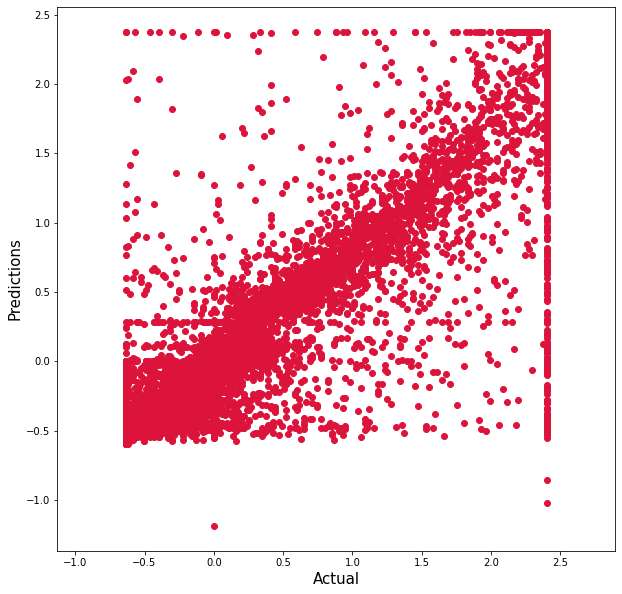

In [17]:
#Plot of actual values versus the predicted values from Artificial neural network
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(y_test, normal_predictions, c='crimson')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [16]:
# creates a tuner model that can test different hyperparameters on Artificial neural network
import keras_tuner
from tensorflow import keras
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [4096, 2048, 1024]),
      activation='relu'))
  model.add(keras.layers.Dense(
      hp.Choice('units', [512,256,128]),
      activation='relu'))
  model.add(keras.layers.Dense(
      hp.Choice('units', [256,128,64]),
      activation='relu'))
  model.add(keras.layers.Dense(
      hp.Choice('units', [128,64,32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='linear'))
  model.compile(loss='mse')
  return model

In [18]:
#Time returns the elapsed time in seconds. This function converts that into hours, minutes and seconds
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d:%02d" % (hour, min, sec) 
start = time.time()


#Initialize keras tuner model by specifying that it should evaluate different parameters
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='loss',
    max_trials=5)
tuner.search(x_train, y_train.values.ravel(), epochs=10)

best_model = tuner.get_best_models()[0]
#Print the best parameters of the model found by keras tuner
print("Best Parameters Found",tuner.get_best_models()[0])


#Performes predictions on the test set using best found Artificial neural network
tuned_pred = best_model.predict(x_test)
k=len(list(x_train.columns))
n = len(tuned_pred)
stop = (time.time() - start)

#Calculates and prints the time taken for training best found Artificial neural network
print('Elapsed Time:', convert_to_preferred_format(stop))
print('======'*5)
print("After GridSearchCV")
print('======'*5)

#Evaluation metrics for the best Artificial neural network on test set
Metrics={}
Metrics['MSE']=[mean_squared_error(y_test,tuned_pred)]
Metrics['RMSE']=[np.sqrt(mean_squared_error(y_test,tuned_pred))]
Metrics['R2_Score']=[r2_score(y_test,tuned_pred)]
Metrics['Adjusted_R2_score']=[1 - ((1-r2_score(y_test,tuned_pred))*(n-1)/(n-k-1))]
metrics_df = pd.DataFrame(Metrics)
print(metrics_df)

#Saves the model so that it can be used for test results comparison
best_model .save('BEST_DL_model')

Trial 3 Complete [00h 03m 23s]
loss: 0.08150962740182877

Best loss So Far: 0.06541959196329117
Total elapsed time: 00h 13m 13s


Best Parameters Found <keras.engine.sequential.Sequential object at 0x7fb6f9724df0>
821/821 [==============================] - 2s 2ms/step
Elapsed Time: 00:13:16
After GridSearchCV
        MSE      RMSE  R2_Score  Adjusted_R2_score
0  0.079991  0.282826  0.913827           0.910349
